## Lab 5 - New Zealand Earthquake Data

This is a notebook to view seismic data from the Ru network of school seismometers in New Zealand. The details are described in our manuscript published in the European Journal of Physics, in 2017. These data are from an earthquake in Rotorua, NZ, in 2016:

We can import some of the familar toolkits we have been using already such as `Obspy` to analyze seismic data.

```python
#you can use these libraries by refering to their appreviation plt., np., pd. or ccrs
#basic plotting library
import matplotlib.pyplot as plt

#scientifc computing library
import numpy as np

#data analysis tool
import pandas as pd

#mapping toolkit
import cartopy.crs as ccrs
import cartopy

#seismic toolkit
import obspy
```

In [ ]:
#Try it here!


In [2]:
# Here I have given you the parameters of the earthquake (but you find this from IRIS/Wilber3, too):
from obspy.core.utcdatetime import UTCDateTime
t0 =  UTCDateTime("2015-09-23 18:47:51")
lat=-38.32
lon=176.14
depth=167 # in km

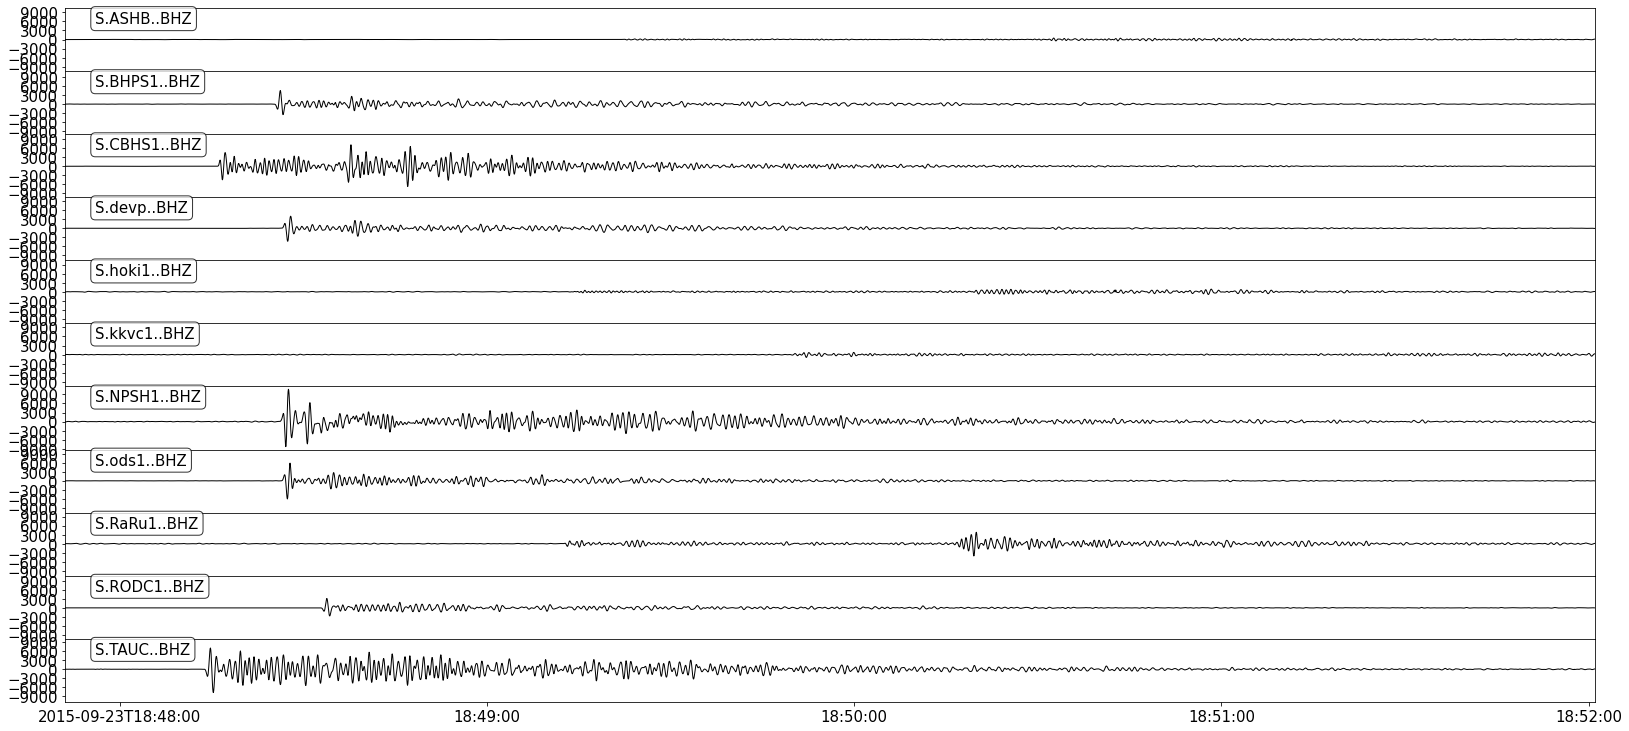

In [3]:
# read and plot the seismic data from the S data up to 250 seconds after the origin time:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from obspy import read
st = read('https://ndownloader.figshare.com/files/6924224')
st.trim(t0,t0+250,pad=True,fill_value=0)
fig = plt.figure(figsize=(25, 10))
st.plot(fig=fig,norm_method='trace')

Note the difference in amplitude and arrival times in these seismograms. Generally, later arrivals and smaller amplitudes mean a greater distance between earthquake and seismometer! But let's be a bit more precise. The cell below computes the travel times for primary and secondary waves as a function of distance to the earthquake. The predictions are based on an earth that is perfectly spherically symmetric:

In [5]:
# Compute travel times based on the IASP91 model:
from obspy.taup import TauPyModel
import numpy as np
model = TauPyModel(model="iasp91")
phases = ['p','P','s','S']
min_degree=0
max_degree=10
npoints=500
data={}
degrees = np.linspace(min_degree, max_degree, npoints)
for degree in degrees:
    tt = model.get_travel_times(distance_in_degree=degree, source_depth_in_km=depth,phase_list=phases)
    for item in tt:
        phase = item.phase.name
        if phase not in data:
            data[phase] = [[], []]
        data[phase][1].append(item.time) # in seconds
        data[phase][0].append(degree)


Now let us plot these arrival time predictions over the seismic data:

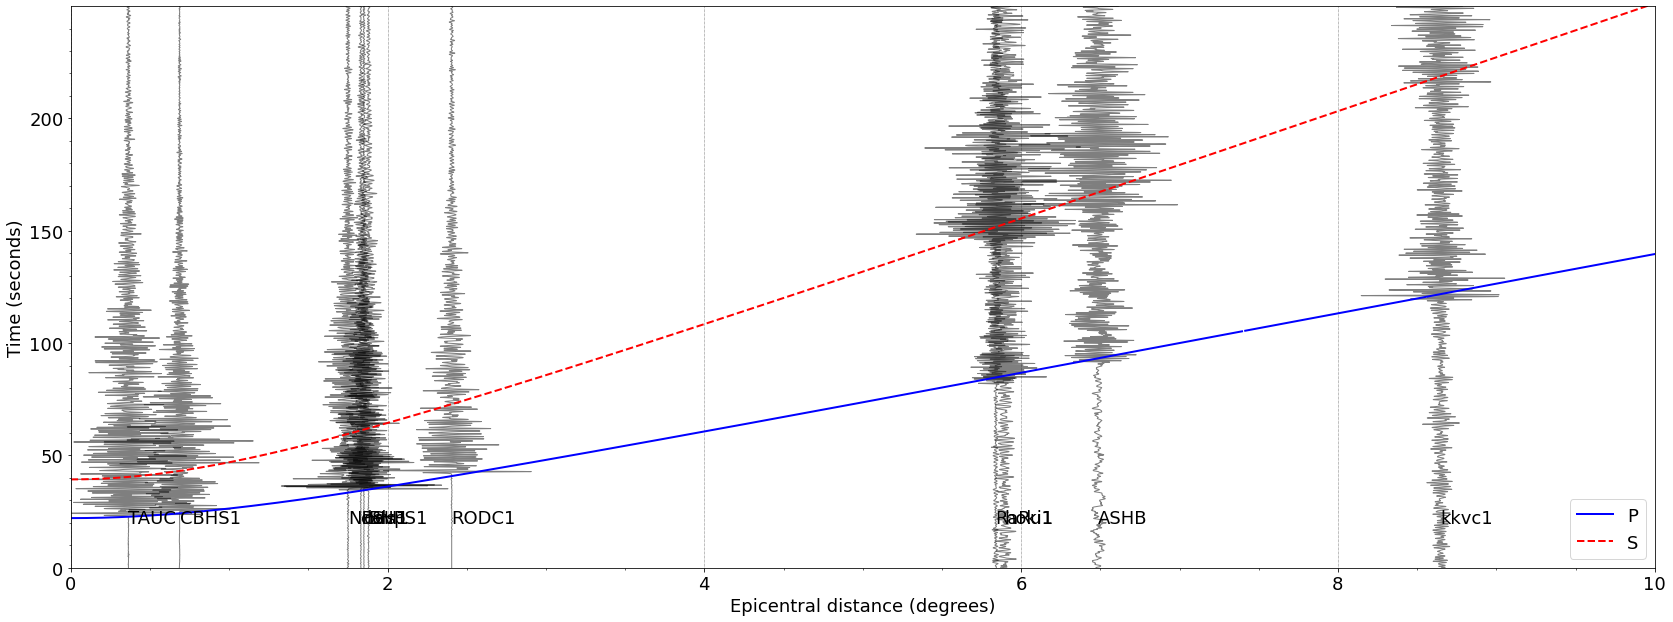

In [6]:
# add lat, lon, and epicentral/angular distance to each trace
from obspy.core.util.attribdict import AttribDict
from obspy.geodetics import locations2degrees

fig = plt.figure(figsize=(25, 10))
for tr in st:
    tr.stats["coordinates"] = {} 
    tr.stats.coordinates.latitude = tr.stats.sac.stla
    tr.stats.coordinates.longitude = tr.stats.sac.stlo    
    tr.stats.network='RU'
    delta = locations2degrees(lat, lon, tr.stats.coordinates.latitude, tr.stats.coordinates.longitude)
    tr.stats.picks= AttribDict({'epic_dist':delta})
    plt.text(tr.stats.picks.epic_dist,20,tr.stats.station)

# plot travel time predictions onto the data:
st.plot(fig=fig,type='section',time_down=False,norm_method='trace',dist_degree='True',ev_coord =(lat,lon),show=False)

# plot the synthetic arrival time curves:
for key, value in data.items():
    if key=='s':
        lines, = plt.plot(np.array(value[0]), value[1],'--r',linewidth=2)
    else:
        linep, = plt.plot(np.array(value[0]), value[1],'b',linewidth=2)
plt.grid()
plt.xlabel('Epicentral distance (degrees)')
plt.ylabel('Time (seconds)')
plt.xlim([0,10])
plt.legend([linep,lines],['P','S'])
plt.show()

The blue curve matches the first arrivals very well. In most seismograms, it is harder to see a clear secondary arrival, but we hope you agree that the red line and secondary arrivals in the data match reasonably well. Finally, we can view how our data and predictions would look like on a map. If we correctly positioned the seismograms on the predicted travel time curves by epicentral distance, the epicentre would be the intersection of circles with a radius that equals this distance: 

In [ ]:
# Now you need to make a map of NZ:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
from matplotlib import cm

from obspy.geodetics import degrees2kilometers
plt.figure(figsize=(10, 10))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
extent = (163, 180, -48, -34)
ax.set_extent(extent)
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='face',facecolor=cfeature.COLORS['land'])
ax.add_feature(land_10m)
ax.stock_img()

# define transforms for markers and (offset)text on the map:
geodetic_transform = projection._as_mpl_transform(ax)
# text_transform     = offset_copy(geodetic_transform, units='dots', x=-25,y=25)

# plot the epicentre:
plt.plot(lon, lat, marker='v', color='black', markersize=24, alpha=1,linestyle='None', transform=geodetic_transform)

#define stations and colours for these:
stats_focus = ['KKVC1','ASHB','hoki1','NPSH1','DEVP1']
colors=iter(cm.gnuplot(np.linspace(0,1,len(stats_focus))))

for tr in st:
    if tr.stats.station in stats_focus:
        statlat= tr.stats.coordinates.latitude
        statlon= tr.stats.coordinates.longitude
        dist = locations2degrees(statlat, statlon, lat, lon)
        rad_km= degrees2kilometers(dist)
        color=next(colors)
        # note the bug in tissot: rad_km is in m, in the current version:
        ax.tissot(edgecolor=color,facecolor='None',lons=statlon,lats=statlat,rad_km=rad_km*1000)
        plt.plot(statlon, statlat, marker='o', color=color,markersize=12, alpha=0.7,linestyle='None',
                 transform=geodetic_transform)
#         plt.text(statlon,statlat,tr.stats.station, verticalalignment='center',horizontalalignment='right',
#                      bbox=dict(facecolor=color, alpha=0.5,boxstyle='round'),transform=text_transform)
            
plt.savefig('mapwithcircles.pdf',bbox_inches='tight')
plt.show()